In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import typing
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data preprocessing

In [2]:
class Chunk:
    def __init__(self, train_part, test_part, feature_names):
        self.train = train_part
        self.test = test_part
        self.features = feature_names
        
    def get_X(self, forvard_time):
        X = list(self.train.P1.values)
        X += list(self.train.P1_diff1.values)
        X += list(self.train.P1_diff2.values)
        X += list(self.train.P1_diff3.values)
        
        X += list(self.train.temperature.values)
        X += list(self.train.t_diff.values)
        X += list(self.train.t_diff1.values)
        X += list(self.train.t_diff2.values)
        
        #X += list(self.train.pressure.values)
        #X += list(self.train.p_diff.values)
        #X += list(self.train.p_diff1.values)
        #X += list(self.train.p_diff2.values)
        
        #X += list(self.train.humidity.values)
        #X += list(self.train.t_diff.values)
        #X += list(self.train.t_diff1.values)
        #X += list(self.train.t_diff2.values)
        
        return X
    
    def get_y(self, forward_time):
        y = self.test.P1.values[forward_time]
        return y

        
    def get_meta_X(self, forward_time, models):
        X = self.get_X(forward_time)
        model = models[forward_time]
        prediction = model.predict([X])[0]
        X_meta = [prediction]
        for feature in self.features:
            X_meta.append(self.test[feature].values[forward_time])
        return X_meta
        
        

In [3]:
def prepare_data(data):
    data['P1'] = data.P1.interpolate()
    
    data['pres_meteo'] = data.pres_meteo.fillna(method='bfill')
    data['temp_meteo'] = data.temp_meteo.fillna(method='bfill')
    data['hum_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['pres_meteo'] = data.pres_meteo.interpolate()
    data['hum_meteo'] = data.hum_meteo.interpolate()
    data['temp_meteo'] = data.temp_meteo.interpolate()
    
    data['pressure'] = data.pressure.interpolate()
    data['humidity'] = data.humidity.interpolate()
    data['temperature'] = data.temperature.interpolate()
    
    data['prec_amount'] = data.prec_amount.fillna(method='bfill')
    data['prec_time'] = data.prec_time.fillna(method='bfill')
    data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
    data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
    data['prec_amount'] = data.prec_amount.astype(float)
    #data['prec_amount'] = data.prec_amount//data.prec_time
    data['prec_time'] = data.prec_time.interpolate()
    data['prec_amount'] = data.prec_amount.interpolate()
    data['wind_direction'] = data.wind_direction.fillna(method='bfill')
    return data

In [4]:
wind_dir = {'Ветер, дующий с востока': 0,
            'Ветер, дующий с востоко-северо-востока': 45/2,
            'Ветер, дующий с северо-востока': 45,
            'Ветер, дующий с северо-северо-востока': 45 + 45/2,
            'Ветер, дующий с севера': 90,
            'Ветер, дующий с северо-северо-запад': 90 + 45/2,
            'Ветер, дующий с северо-запада': 135,
            'Ветер, дующий с западо-северо-запада': 135 + 45/2,
            'Ветер, дующий с запада': 180,
            'Ветер, дующий с западо-юго-запада': 180+45/2,
            'Ветер, дующий с юго-запада': 225,
            'Ветер, дующий с юго-юго-запада': 225 + 45/2,
            'Ветер, дующий с юга': 270,
            'Ветер, дующий с юго-юго-востока': 270 + 45/2,
            'Ветер, дующий с юго-востока': 315,
            'Ветер, дующий с востоко-юго-востока': 315 + 45/2,
            'Штиль, безветрие': None,
            }

def add_features(data):
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['sin_day'] = np.sin(2*np.pi*data.day_of_week/7)
    data['cos_day'] = np.cos(2*np.pi*data.day_of_week/7)
    data['sin_hour'] = np.sin(2*np.pi*data.hour/24)
    data['cos_hour'] = np.cos(2*np.pi*data.hour/24)
    
    data['P1_diff1'] = data.P1.diff(periods=1)
    data['P1_diff2'] = data.P1_diff1.diff(periods=1)
    data['P1_diff3'] = data.P1_diff2.diff(periods=1)
    data['t_diff'] = data.temperature.diff(periods=1)
    data['t_diff1'] = data.t_diff.diff(periods=1)
    data['t_diff2'] = data.t_diff1.diff(periods=1)
    data['p_diff'] = data.pressure.diff(periods=1)
    data['p_diff1'] = data.p_diff.diff(periods=1)
    data['p_diff2'] = data.p_diff1.diff(periods=1)
    data['h_diff'] = data.humidity.diff(periods=1)
    data['h_diff1'] = data.h_diff.diff(periods=1)
    data['h_diff2'] = data.h_diff1.diff(periods=1)
    
    data['wind_direction'] = data.wind_direction.map(wind_dir)
    data["wind_sin"] = np.sin(np.radians(data.wind_direction))
    data["wind_cos"] = np.cos(np.radians(data.wind_direction))
    data['wind_sin'] = data.wind_sin.fillna(value=2)
    data['wind_cos'] = data.wind_cos.fillna(value=2)
    
    data['temp_diff'] = data.temp_meteo.diff(periods=3)
    data['humidity_diff'] = data.hum_meteo.diff(periods=3)
    data['pressure_diff'] = data.pres_meteo.diff(periods=3)
    data['wind_sin_diff'] = data.wind_sin.diff(periods=3)
    data['wind_cos_diff'] = data.wind_cos.diff(periods=3)
    data['temp_diff3'] = data.temp_meteo.diff(periods=9)
    data['humidity_diff3'] = data.hum_meteo.diff(periods=9)
    data['pressure_diff3'] = data.pres_meteo.diff(periods=9)
    data['wind_sin_diff3'] = data.wind_sin.diff(periods=9)
    data['wind_cos_diff3'] = data.wind_cos.diff(periods=9)
    return data

In [5]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')

In [6]:
data.columns

Index(['P1', 'P2', 'pressure', 'temperature', 'humidity', 'temp_meteo',
       'pres_meteo', 'hum_meteo', 'wind_direction', 'wind_speed',
       'precipitation', 'prec_amount', 'prec_time', 'visibility',
       'dew_point_temp'],
      dtype='object')

In [7]:
sel_columns = ['P1', 'pres_meteo', 'temp_meteo', 'hum_meteo', 'wind_direction',
               'wind_speed', 'prec_amount', 'prec_time', 'pressure', 'temperature', 'humidity']
data = data[sel_columns]

In [8]:
data = prepare_data(data)
data = add_features(data)
data = data.resample('1H').mean()

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9001 entries, 2019-04-01 00:00:00+00:00 to 2020-04-10 00:00:00+00:00
Freq: H
Data columns (total 41 columns):
P1                9001 non-null float64
pres_meteo        9001 non-null float64
temp_meteo        9001 non-null float64
hum_meteo         9001 non-null float64
wind_direction    7399 non-null float64
wind_speed        9001 non-null float64
prec_amount       9001 non-null float64
prec_time         9001 non-null float64
pressure          9001 non-null float64
temperature       9001 non-null float64
humidity          9001 non-null float64
day_of_week       9001 non-null float64
hour              9001 non-null float64
sin_day           9001 non-null float64
cos_day           9001 non-null float64
sin_hour          9001 non-null float64
cos_hour          9001 non-null float64
P1_diff1          9001 non-null float64
P1_diff2          9001 non-null float64
P1_diff3          9001 non-null float64
t_diff            9001 non-null float

# Split data on chunks

In [10]:
train_data = data['2019-04-02 00:00:00+00:00':str(data.index[-1] - datetime.timedelta(days=50))]
test_data = data[str(data.index[-1] - datetime.timedelta(days=50)):]

In [11]:
def pp(start, end, n):
    """generation of random datetime indexes"""
    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.DatetimeIndex((10**9*np.random.randint(start_u, end_u, n)).view('M8[ns]'))

In [12]:
def generate_chunks(series, n, start, end, chunk_len, test_len, features):
    chunks = []
    for idx in pp(start, end, n):
        train_part = series[str(idx):str(idx+datetime.timedelta(hours=chunk_len-test_len))]
        test_part = series[str(idx+datetime.timedelta(hours=chunk_len-test_len)):str(idx+datetime.timedelta(hours=chunk_len))]
        chunk = Chunk(train_part, test_part, features)
        chunks.append(chunk)
    return chunks

In [13]:
chunk_len = 48
test_len = 24
train_start_idx = train_data.index[0]
train_end_idx = train_data.index[-1] - datetime.timedelta(hours=chunk_len)
train_num_samples = 2000
features = ['pres_meteo', 'temp_meteo', 'hum_meteo', 'wind_speed', 'prec_amount',
           'sin_day', 'cos_day', 'sin_hour', 'cos_hour', 'wind_sin', 'wind_cos', 'temp_diff', 'humidity_diff',
           'pressure_diff', 'temp_diff3', 'humidity_diff3',
           'pressure_diff3']
np.random.seed(42)

train_chunks = generate_chunks(train_data, train_num_samples,
                               train_start_idx, train_end_idx,
                               chunk_len, test_len, features)

test_start_idx = test_data.index[0]
test_end_idx = test_data.index[-1] - datetime.timedelta(hours=chunk_len)
test_num_samples = 300

test_chunks = generate_chunks(test_data, test_num_samples,
                              test_start_idx, test_end_idx,
                              chunk_len, test_len,
                              features)

In [14]:
train, train_meta = train_test_split(train_chunks, test_size=0.5, random_state=42)

# Train models

In [15]:
def train_models(model, chunks, num_models):
    models = []
    for i in range(num_models):
        X = [chunk.get_X(i) for chunk in chunks]
        local_model = clone(model)
        y = [chunk.get_y(i) for chunk in chunks]
        local_model.fit(X, y)
        models.append(local_model)
    return models

In [16]:
def get_mae(models, chunks):
    scores = []
    for i in range(len(models)):
        X = [chunk.get_X(i) for chunk in chunks]
        local_model = models[i]
        prediction = local_model.predict(X)
        y = [chunk.get_y(i) for chunk in chunks]
        mae = mean_absolute_error(y, prediction)
        scores.append(mae)
    return scores

In [17]:
%%time
#mod = RandomForestRegressor(min_samples_leaf=3, random_state=42)
mod = Lasso(alpha=0.7, random_state=42, max_iter=1500)
models = train_models(mod, train, test_len)

CPU times: user 10.9 s, sys: 3.28 s, total: 14.2 s
Wall time: 5.83 s


In [18]:
mae = get_mae(models, test_chunks)

In [19]:
alpha = [0.3, 0.4, 0.6, 0.7, 1]
for i in range(len(alpha)):
    mod = Lasso(alpha=alpha[i], random_state=42)
    models = train_models(mod, train, test_len)
    mae = get_mae(models, test_chunks)
    print(alpha[i], np.mean(mae))

0.3 6.934548688751292
0.4 6.928468650414923
0.6 6.912866611689033
0.7 6.912575931872471
1 6.915831738556616


In [20]:
mae, np.mean(mae)

([1.4913353899267812,
  2.7512745810275216,
  3.756833438752789,
  4.580585878296887,
  5.080386595625764,
  5.516955718391661,
  6.05902319417212,
  6.20357022887689,
  6.157231953879743,
  6.3791856635634625,
  6.7069612286684945,
  7.0547844995830475,
  7.2326886959986645,
  7.42891638418601,
  7.654897948435705,
  8.253158291293524,
  8.578936873438193,
  8.685004980892378,
  8.853320837927651,
  8.854016127275672,
  9.105965273059564,
  9.304903561249832,
  9.976442048699663,
  10.313582332136756],
 6.915831738556616)

# Train meta models

In [21]:
def train_meta_models(meta_model, models, chunks, num_models):
    meta_models = []
    for i in range(num_models):
        X = [chunk.get_meta_X(i, models) for chunk in chunks]
        local_model = clone(meta_model)
        y = [chunk.get_y(i) for chunk in chunks]
        local_model.fit(X, y)
        meta_models.append(local_model)
    return meta_models

In [22]:
def get_meta_mae(models, meta_models, chunks):
    scores = []
    for i in range(len(models)):
        X = [chunk.get_meta_X(i, models) for chunk in chunks]
        local_model = meta_models[i]
        prediction = local_model.predict(X)
        y = [chunk.get_y(i) for chunk in chunks]
        mae = mean_absolute_error(y, prediction)
        scores.append(mae)
    return scores

In [23]:
def get_predictions(models, meta_models, chunk):
    predictions = []
    for i in range(len(models)):
        X = [chunk.get_meta_X(i, models) ]
        local_model = meta_models[i]
        prediction = local_model.predict(X)[0]
        predictions.append(prediction)
    return predictions

In [24]:
%%time
#meta_model = Lasso(alpha=0.2, random_state=42)
#meta_model = Ridge(alpha=0.6, random_state=42)
meta_model = RandomForestRegressor(min_samples_leaf=20, random_state=42)
meta_models = train_meta_models(meta_model, models, train_meta, test_len)

CPU times: user 19.5 s, sys: 97.3 ms, total: 19.6 s
Wall time: 19.8 s


In [25]:
meta_mae = get_meta_mae(models, meta_models, test_chunks)

In [26]:
def get_feature_impotances(models):
    importance = models[0].feature_importances_
    for mod in models[1:]:
        local_importance = mod.feature_importances_
        importance += local_importance
    importance = importance / len(models)
    return list(importance)

In [27]:
get_feature_impotances(meta_models)

[0.6773756330630638,
 0.012264192895671001,
 0.01202714225611004,
 0.16825276084716875,
 0.043189535003025,
 0.01933513029550241,
 0.001953938035884092,
 0.0015213276376480225,
 0.0046766183812192805,
 0.00588585942468032,
 0.00593421062321894,
 0.04641572084491189,
 0.00023513387343158715,
 5.130702148763622e-05,
 0.00030474548443234063,
 0.00023788144030324746,
 8.37631926730979e-05,
 0.00025509967956868524]

In [28]:
np.mean(meta_mae)

5.705769817896392

In [29]:
np.mean(meta_mae)

5.705769817896392

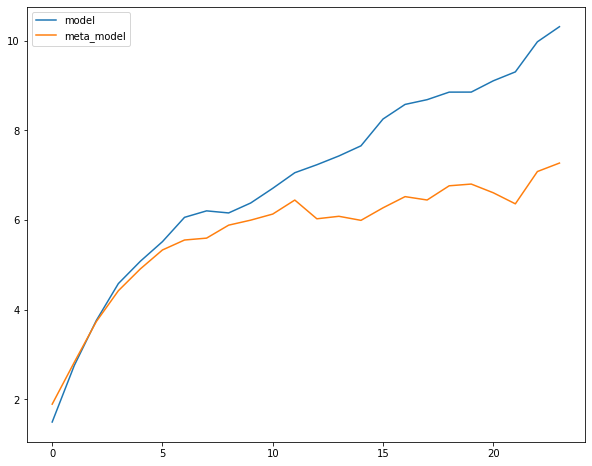

In [36]:
plt.plot(mae, label='model')
plt.plot(meta_mae, label='meta_model')
plt.legend()

In [31]:
mae, np.mean(mae)

([1.4913353899267812,
  2.7512745810275216,
  3.756833438752789,
  4.580585878296887,
  5.080386595625764,
  5.516955718391661,
  6.05902319417212,
  6.20357022887689,
  6.157231953879743,
  6.3791856635634625,
  6.7069612286684945,
  7.0547844995830475,
  7.2326886959986645,
  7.42891638418601,
  7.654897948435705,
  8.253158291293524,
  8.578936873438193,
  8.685004980892378,
  8.853320837927651,
  8.854016127275672,
  9.105965273059564,
  9.304903561249832,
  9.976442048699663,
  10.313582332136756],
 6.915831738556616)

In [32]:
meta_mae, np.mean(meta_mae)

([1.8898919710741946,
  2.82324706998824,
  3.732195055166778,
  4.421452734181667,
  4.909581434368751,
  5.33117854135947,
  5.553110161718628,
  5.595244591135737,
  5.884594826807711,
  5.996530259774915,
  6.132220188213051,
  6.4447170538720435,
  6.026686158242319,
  6.082413220951861,
  5.991938357498144,
  6.271561046323717,
  6.521278096796351,
  6.446053465375142,
  6.7630927169962884,
  6.801728608271946,
  6.607367273139004,
  6.360505856856879,
  7.081452529587274,
  7.270434411813263],
 5.705769817896392)

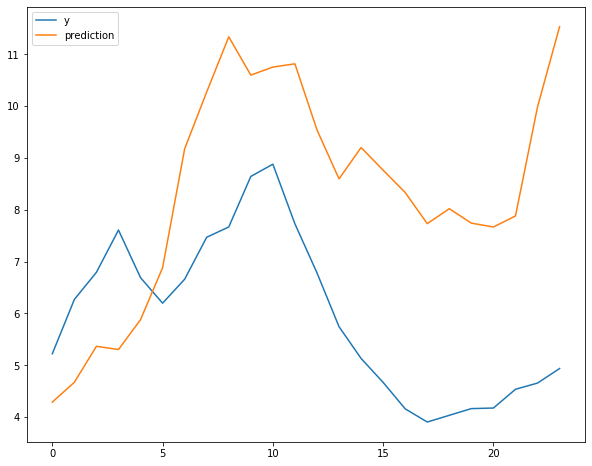

In [35]:
chunk_num=205
plt.plot([test_chunks[chunk_num].get_y(i) for i in range(len(meta_models))], label='y')
plt.plot(get_predictions(models, meta_models, test_chunks[chunk_num]), label='prediction')
plt.legend()